## Introduction ##

This is my first work of machine learning. the notebook is written in python and has inspired from ["Exploring Survival on Titanic" by Megan Risdal, a Kernel in R on Kaggle][1].


  [1]: https://www.kaggle.com/mrisdal/titanic/exploring-survival-on-the-titanic

In [569]:
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torch.optim as optim

from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import seaborn as sns

In [570]:
%matplotlib inline
import numpy as np
import pandas as pd
import re as re

train = pd.read_csv('train.csv', header = 0, dtype={'Age': np.float64})
test  = pd.read_csv('test.csv' , header = 0, dtype={'Age': np.float64})
full_data = [train, test]

print (train.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB
None


# Feature Engineering #

## 1. Pclass ##
there is no missing value on this feature and already a numerical value. so let's check it's impact on our train set.

In [571]:
print (train[['Pclass', 'Survived']].groupby(['Pclass'], as_index=False).mean())

   Pclass  Survived
0       1  0.629630
1       2  0.472826
2       3  0.242363


## 2. Sex ##

In [572]:
print (train[["Sex", "Survived"]].groupby(['Sex'], as_index=False).mean())

      Sex  Survived
0  female  0.742038
1    male  0.188908


## 3. SibSp and Parch ##
With the number of siblings/spouse and the number of children/parents we can create new feature called Family Size.

In [573]:
for dataset in full_data:
    dataset['FamilySize'] = dataset['SibSp'] + dataset['Parch'] + 1
print (train[['FamilySize', 'Survived']].groupby(['FamilySize'], as_index=False).mean())

   FamilySize  Survived
0           1  0.303538
1           2  0.552795
2           3  0.578431
3           4  0.724138
4           5  0.200000
5           6  0.136364
6           7  0.333333
7           8  0.000000
8          11  0.000000


it seems has a good effect on our prediction but let's go further and categorize people to check whether they are alone in this ship or not.

In [574]:
for dataset in full_data:
    dataset['IsAlone'] = 0
    dataset.loc[dataset['FamilySize'] == 1, 'IsAlone'] = 1
print (train[['IsAlone', 'Survived']].groupby(['IsAlone'], as_index=False).mean())

   IsAlone  Survived
0        0  0.505650
1        1  0.303538


good! the impact is considerable.

## 4. Embarked ##
the embarked feature has some missing value. and we try to fill those with the most occurred value ( 'S' ).

In [575]:
for dataset in full_data:
    dataset['Embarked'] = dataset['Embarked'].fillna('S')
print (train[['Embarked', 'Survived']].groupby(['Embarked'], as_index=False).mean())

  Embarked  Survived
0        C  0.553571
1        Q  0.389610
2        S  0.339009


## 5. Fare ##
Fare also has some missing value and we will replace it with the median. then we categorize it into 4 ranges.

In [576]:
for dataset in full_data:
    dataset['Fare'] = dataset['Fare'].fillna(train['Fare'].median())
train['CategoricalFare'] = pd.qcut(train['Fare'], 4)
print (train[['CategoricalFare', 'Survived']].groupby(['CategoricalFare'], as_index=False).mean())

   CategoricalFare  Survived
0   (-0.001, 7.91]  0.197309
1   (7.91, 14.454]  0.303571
2   (14.454, 31.0]  0.454955
3  (31.0, 512.329]  0.581081


/tmp/ipykernel_57679/3679174374.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  print (train[['CategoricalFare', 'Survived']].groupby(['CategoricalFare'], as_index=False).mean())


## 6. Age ##
we have plenty of missing values in this feature. # generate random numbers between (mean - std) and (mean + std).
then we categorize age into 5 range.

In [577]:
for dataset in full_data:
    age_avg 	   = dataset['Age'].mean()
    age_std 	   = dataset['Age'].std()
    age_null_count = dataset['Age'].isnull().sum()
    
    age_null_random_list = np.random.randint(age_avg - age_std, age_avg + age_std, size=age_null_count)
    dataset['Age'][np.isnan(dataset['Age'])] = age_null_random_list
    dataset['Age'] = dataset['Age'].astype(int)
    
train['CategoricalAge'] = pd.cut(train['Age'], 5)

print (train[['CategoricalAge', 'Survived']].groupby(['CategoricalAge'], as_index=False).mean())

  CategoricalAge  Survived
0  (-0.08, 16.0]  0.528302
1   (16.0, 32.0]  0.352174
2   (32.0, 48.0]  0.379592
3   (48.0, 64.0]  0.434783
4   (64.0, 80.0]  0.090909


/tmp/ipykernel_57679/3509540359.py:7: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  dataset['Age'][np.isnan(dataset['Age'])] = age_null_random_list
/tmp/ipykernel_57679/3509540359.py:7: SettingWithCopyWarning: 
A value is trying to be set on

## 7. Name ##
inside this feature we can find the title of people.

In [578]:
def get_title(name):
	title_search = re.search(' ([A-Za-z]+)\.', name)
	# If the title exists, extract and return it.
	if title_search:
		return title_search.group(1)
	return ""

for dataset in full_data:
    dataset['Title'] = dataset['Name'].apply(get_title)

print(pd.crosstab(train['Title'], train['Sex']))

Sex       female  male
Title                 
Capt           0     1
Col            0     2
Countess       1     0
Don            0     1
Dr             1     6
Jonkheer       0     1
Lady           1     0
Major          0     2
Master         0    40
Miss         182     0
Mlle           2     0
Mme            1     0
Mr             0   517
Mrs          125     0
Ms             1     0
Rev            0     6
Sir            0     1


 so we have titles. let's categorize it and check the title impact on survival rate.

In [579]:
for dataset in full_data:
    dataset['Title'] = dataset['Title'].replace(['Lady', 'Countess','Capt', 'Col',\
 	'Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')

    dataset['Title'] = dataset['Title'].replace('Mlle', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Ms', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Mme', 'Mrs')

print (train[['Title', 'Survived']].groupby(['Title'], as_index=False).mean())

    Title  Survived
0  Master  0.575000
1    Miss  0.702703
2      Mr  0.156673
3     Mrs  0.793651
4    Rare  0.347826


# Data Cleaning #
great! now let's clean our data and map our features into numerical values.

In [580]:
for dataset in full_data:
    # Mapping Sex
    dataset['Sex'] = dataset['Sex'].map( {'female': 0, 'male': 1} ).astype(int)
    
    # Mapping titles
    title_mapping = {"Mr": 1, "Miss": 2, "Mrs": 3, "Master": 4, "Rare": 5}
    dataset['Title'] = dataset['Title'].map(title_mapping)
    dataset['Title'] = dataset['Title'].fillna(0)
    
    # Mapping Embarked
    dataset['Embarked'] = dataset['Embarked'].map( {'S': 0, 'C': 1, 'Q': 2} ).astype(int)
    
    # Mapping Fare
    dataset.loc[ dataset['Fare'] <= 7.91, 'Fare'] 						        = 0
    dataset.loc[(dataset['Fare'] > 7.91) & (dataset['Fare'] <= 14.454), 'Fare'] = 1
    dataset.loc[(dataset['Fare'] > 14.454) & (dataset['Fare'] <= 31), 'Fare']   = 2
    dataset.loc[ dataset['Fare'] > 31, 'Fare'] 							        = 3
    dataset['Fare'] = dataset['Fare'].astype(int)
    
    # Mapping Age
    dataset.loc[ dataset['Age'] <= 16, 'Age'] 					       = 0
    dataset.loc[(dataset['Age'] > 16) & (dataset['Age'] <= 32), 'Age'] = 1
    dataset.loc[(dataset['Age'] > 32) & (dataset['Age'] <= 48), 'Age'] = 2
    dataset.loc[(dataset['Age'] > 48) & (dataset['Age'] <= 64), 'Age'] = 3
    dataset.loc[ dataset['Age'] > 64, 'Age']                           = 4

# Feature Selection
drop_elements = ['PassengerId', 'Name', 'Ticket', 'Cabin', 'SibSp',\
                 'Parch', 'FamilySize']
train = train.drop(drop_elements, axis = 1)
train = train.drop(['CategoricalAge', 'CategoricalFare'], axis = 1)

test  = test.drop(drop_elements, axis = 1)

train.head(10)


,Survived,Pclass,Sex,Age,Fare,Embarked,IsAlone,Title
0,0,3,1,1,0,0,0,1
1,1,1,0,2,3,1,0,3
2,1,3,0,1,1,0,1,2
3,1,1,0,2,3,0,0,3
4,0,3,1,2,1,0,1,1
5,0,3,1,1,1,2,1,1
6,0,1,1,3,3,0,1,1
7,0,3,1,0,2,0,0,4
8,1,3,0,1,1,0,0,3
9,1,2,0,0,2,1,0,3


In [581]:
if torch.cuda.is_available():
    print("CUDA is available")
else:
    print("CUDA is not available")
    
device = torch.device("cuda" if (torch.cuda.is_available()) else "cpu")

print("Running on " + torch.cuda.get_device_name(0) if torch.cuda.is_available() else "cpu")

CUDA is available
Running on NVIDIA GeForce GTX 1060 6GB


In [582]:
features = ["Pclass","Age", "Fare","Embarked", "Title"]
train = pd.get_dummies(train, columns=features).astype('float32')
test = pd.get_dummies(test, columns=features).astype('float32')

print(train.columns)
print(test.columns)
X_train = train.drop("Survived", axis=1)
y_train = train["Survived"]
X_test = test

train.head(10)


Index(['Survived', 'Sex', 'IsAlone', 'Pclass_1', 'Pclass_2', 'Pclass_3',
       'Age_0', 'Age_1', 'Age_2', 'Age_3', 'Age_4', 'Fare_0', 'Fare_1',
       'Fare_2', 'Fare_3', 'Embarked_0', 'Embarked_1', 'Embarked_2', 'Title_1',
       'Title_2', 'Title_3', 'Title_4', 'Title_5'],
      dtype='object')
Index(['Sex', 'IsAlone', 'Pclass_1', 'Pclass_2', 'Pclass_3', 'Age_0', 'Age_1',
       'Age_2', 'Age_3', 'Age_4', 'Fare_0', 'Fare_1', 'Fare_2', 'Fare_3',
       'Embarked_0', 'Embarked_1', 'Embarked_2', 'Title_1', 'Title_2',
       'Title_3', 'Title_4', 'Title_5'],
      dtype='object')


,Survived,Sex,IsAlone,Pclass_1,Pclass_2,Pclass_3,Age_0,Age_1,Age_2,Age_3,...,Fare_2,Fare_3,Embarked_0,Embarked_1,Embarked_2,Title_1,Title_2,Title_3,Title_4,Title_5
0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
2,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
5,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0
6,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
7,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
8,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
9,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0


In [583]:
print(X_train.shape, y_train.shape, X_test.shape)

(891, 22) (891,) (418, 22)


In [584]:
import collections

dropout_prob = 0.2
weight_decay = 1e-6
lr=1e-5
momentum=0
dampening=0



input_size = X_train.shape[1]
hidden_layer_sizes = [512, 512, 512, 256]


model_dense = nn.Sequential(collections.OrderedDict([
    ('hidden1', nn.Linear(input_size, hidden_layer_sizes[0])),
    ('activation1', nn.ReLU()),
    ('dropout1', nn.Dropout(dropout_prob)),  
    ('hidden2', nn.Linear(hidden_layer_sizes[0], hidden_layer_sizes[1])),
    ('activation2', nn.ReLU()),
    ('dropout2', nn.Dropout(dropout_prob)),
    ('hidden3', nn.Linear(hidden_layer_sizes[1], hidden_layer_sizes[2])),
    ('activation3', nn.ReLU()),
    ('dropout3', nn.Dropout(dropout_prob)),
    ('hidden4', nn.Linear(hidden_layer_sizes[2], hidden_layer_sizes[3])),
    ('activation4', nn.ReLU()),
    ('dropout4', nn.Dropout(dropout_prob)),
    ('output', nn.Linear(hidden_layer_sizes[3], 1)),
    ('activation5', nn.Sigmoid())
]))


simple_hl_sizes = [64,32]
model_simple = nn.Sequential(collections.OrderedDict([
    ('hidden1', nn.Linear(input_size, simple_hl_sizes[0])),
    ('activation1', nn.ReLU()),
    ('dropout1', nn.Dropout(dropout_prob)),
    ('hidden2', nn.Linear(simple_hl_sizes[0], simple_hl_sizes[1])),
    ('activation2', nn.ReLU()),
    ('dropout2', nn.Dropout(dropout_prob)),
    ('output', nn.Linear(simple_hl_sizes[-1], 1)),
    ('activation4', nn.Sigmoid())
        ]))


loss_fn = nn.BCELoss()
"""
optimizer_dense = torch.optim.Adam(model_dense.parameters())#, weight_decay=weight_decay)
optimizer_simple = torch.optim.Adam(model_simple.parameters())#, weight_decay=weight_decay)
"""
optimizer_dense = torch.optim.SGD(params=model_dense.parameters(),lr=lr, momentum=momentum, dampening=dampening, weight_decay=weight_decay)
optimizer_simple = torch.optim.SGD(params=model_simple.parameters(),lr=lr, momentum=momentum, dampening=dampening, weight_decay=weight_decay)

print("Dense MLP Model with L2 regularization and Dropout")
print(model_dense)
print("\n\n")
print("Simple MLP Model with L2 regularization and Dropout")
print(model_simple)

Dense MLP Model with L2 regularization and Dropout
Sequential(
  (hidden1): Linear(in_features=22, out_features=512, bias=True)
  (activation1): ReLU()
  (dropout1): Dropout(p=0.2, inplace=False)
  (hidden2): Linear(in_features=512, out_features=512, bias=True)
  (activation2): ReLU()
  (dropout2): Dropout(p=0.2, inplace=False)
  (hidden3): Linear(in_features=512, out_features=512, bias=True)
  (activation3): ReLU()
  (dropout3): Dropout(p=0.2, inplace=False)
  (hidden4): Linear(in_features=512, out_features=256, bias=True)
  (activation4): ReLU()
  (dropout4): Dropout(p=0.2, inplace=False)
  (output): Linear(in_features=256, out_features=1, bias=True)
  (activation5): Sigmoid()
)



Simple MLP Model with L2 regularization and Dropout
Sequential(
  (hidden1): Linear(in_features=22, out_features=64, bias=True)
  (activation1): ReLU()
  (dropout1): Dropout(p=0.2, inplace=False)
  (hidden2): Linear(in_features=64, out_features=32, bias=True)
  (activation2): ReLU()
  (dropout2): Dropout(p

In [585]:
y_train = torch.tensor(y_train.values.astype('float32')).reshape(-1, 1)
X_train = torch.tensor(X_train.values.astype('float32'))
X_test = torch.tensor(X_test.values.astype('float32'))

print(y_train.type(), X_train.type(), X_test.type())
print(X_train.shape, y_train.shape, X_test.shape)

torch.FloatTensor torch.FloatTensor torch.FloatTensor
torch.Size([891, 22]) torch.Size([891, 1]) torch.Size([418, 22])


In [586]:
from sklearn.model_selection import StratifiedKFold
import torch
import torch.optim as optim
import torch.nn as nn
import datetime

def cross_validate(model, n_epochs, optimizer, loss_fn, X_train, y_train, n_splits=9, batch_size=32, shuffle=True, device=device,epoch_print_gap = 1):
    skf = StratifiedKFold(n_splits=n_splits, shuffle=shuffle, random_state=42)
    fold_results = []
    train_results = []

    for fold, (train_index, valid_index) in enumerate(skf.split(X_train, y_train)):
        print(f"Fold {fold+1}/{n_splits}")
        X_train_fold, X_valid_fold = X_train[train_index], X_train[valid_index]
        y_train_fold, y_valid_fold = y_train[train_index], y_train[valid_index]
        
        train_dataset = torch.utils.data.TensorDataset(X_train_fold, y_train_fold)
        valid_dataset = torch.utils.data.TensorDataset(X_valid_fold, y_valid_fold)

        train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=shuffle)
        valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=batch_size)

        model = model.to(device)

        for epoch in range(1, n_epochs + 1):
            model.train()
            loss_train = 0.0
            correct = 0
            total = 0
            for X_train_batch, y_train_batch in train_loader:
                X_train_batch, y_train_batch = X_train_batch.to(device), y_train_batch.to(device)
                optimizer.zero_grad()
                outputs = model(X_train_batch)
                loss = loss_fn(outputs, y_train_batch)
                loss.backward()
                optimizer.step()
                loss_train += loss.item()
                total += y_train_batch.size(0)
                correct += ((outputs > 0.5).float() == y_train_batch).sum().item()
                
                
                
                
            accuracy_train = 100 *correct / total

            if epoch == 1 or epoch % epoch_print_gap == 0:
                print('{} Epoch {}, Training loss {}, Training Accuracy {:.2f}%'.format(
                    datetime.datetime.now(), epoch, float(loss_train), float(accuracy_train)))
        train_results.append(accuracy_train)

        model.eval()
        correct = 0
        total = 0
        
        with torch.no_grad():
            for X_valid_batch, y_valid_batch in valid_loader:
                X_valid_batch, y_valid_batch = X_valid_batch.to(device), y_valid_batch.to(device)
                outputs = model(X_valid_batch)
                predicted = (outputs > 0.5).float()
                total += y_valid_batch.size(0)
                correct += (predicted == y_valid_batch).sum().item()
   
                

                
        fold_accuracy = 100 *correct / total
        print('Fold Accuracy: {:.2f}%'.format(fold_accuracy))
        fold_results.append(fold_accuracy)

    return (train_results, fold_results)

In [587]:
dropout_prob = 0
weight_decay = 1e-4
lr = 0.1
momentum = 0.9
dampening = 0.5
n_epochs = 10


In [588]:
dropout_prob = 0
weight_decay = 0
lr = 0.1
momentum = 0.9
dampening = 0.5
n_epochs = 50
optimizer_simple = torch.optim.SGD(params=model_simple.parameters(),lr=lr, momentum=momentum, dampening=dampening, weight_decay=weight_decay)
model_simple.load_state_dict(torch.load('tsingle_epoch_simple.pth'))

train_simple, test_simple = cross_validate(model = model_simple,
               n_epochs = n_epochs,
               optimizer = optimizer_simple,
               loss_fn = loss_fn,
               X_train = X_train,
               y_train = y_train,
               n_splits=5, 
               batch_size=32, 
               shuffle=True, 
               device=device,
               epoch_print_gap=50)


Fold 1/5
2024-02-11 23:31:45.644693 Epoch 1, Training loss 14.132889151573181, Training Accuracy 63.20%


2024-02-11 23:31:47.526045 Epoch 50, Training loss 8.380046844482422, Training Accuracy 86.52%
Fold Accuracy: 79.33%
Fold 2/5
2024-02-11 23:31:47.567146 Epoch 1, Training loss 9.072867810726166, Training Accuracy 83.87%
2024-02-11 23:31:49.198049 Epoch 50, Training loss 7.488730818033218, Training Accuracy 86.12%
Fold Accuracy: 83.71%
Fold 3/5
2024-02-11 23:31:49.234984 Epoch 1, Training loss 8.486959308385849, Training Accuracy 84.71%
2024-02-11 23:31:50.857020 Epoch 50, Training loss 7.008007884025574, Training Accuracy 86.54%
Fold Accuracy: 83.15%
Fold 4/5
2024-02-11 23:31:50.893850 Epoch 1, Training loss 7.835905507206917, Training Accuracy 86.54%
2024-02-11 23:31:52.547236 Epoch 50, Training loss 7.281293213367462, Training Accuracy 85.27%
Fold Accuracy: 84.83%
Fold 5/5
2024-02-11 23:31:52.585553 Epoch 1, Training loss 7.735962808132172, Training Accuracy 86.40%
2024-02-11 23:31:54.236217 Epoch 50, Training loss 6.910604178905487, Training Accuracy 87.24%
Fold Accuracy: 82.02%


In [589]:
"""
optimizer_dense = torch.optim.SGD(params=model_dense.parameters(),lr=lr, momentum=momentum, dampening=dampening, weight_decay=weight_decay)
train_dense, test_dense = cross_validate(model = model_dense,
               n_epochs = n_epochs,
               optimizer = optimizer_dense,
               loss_fn = loss_fn,
               X_train = X_train,
               y_train = y_train,
               n_splits=2, 
               batch_size=128, 
               shuffle=True, 
               device=device,
               epoch_print_gap=50)
"""

'\noptimizer_dense = torch.optim.SGD(params=model_dense.parameters(),lr=lr, momentum=momentum, dampening=dampening, weight_decay=weight_decay)\ntrain_dense, test_dense = cross_validate(model = model_dense,\n               n_epochs = n_epochs,\n               optimizer = optimizer_dense,\n               loss_fn = loss_fn,\n               X_train = X_train,\n               y_train = y_train,\n               n_splits=2, \n               batch_size=128, \n               shuffle=True, \n               device=device,\n               epoch_print_gap=50)\n'

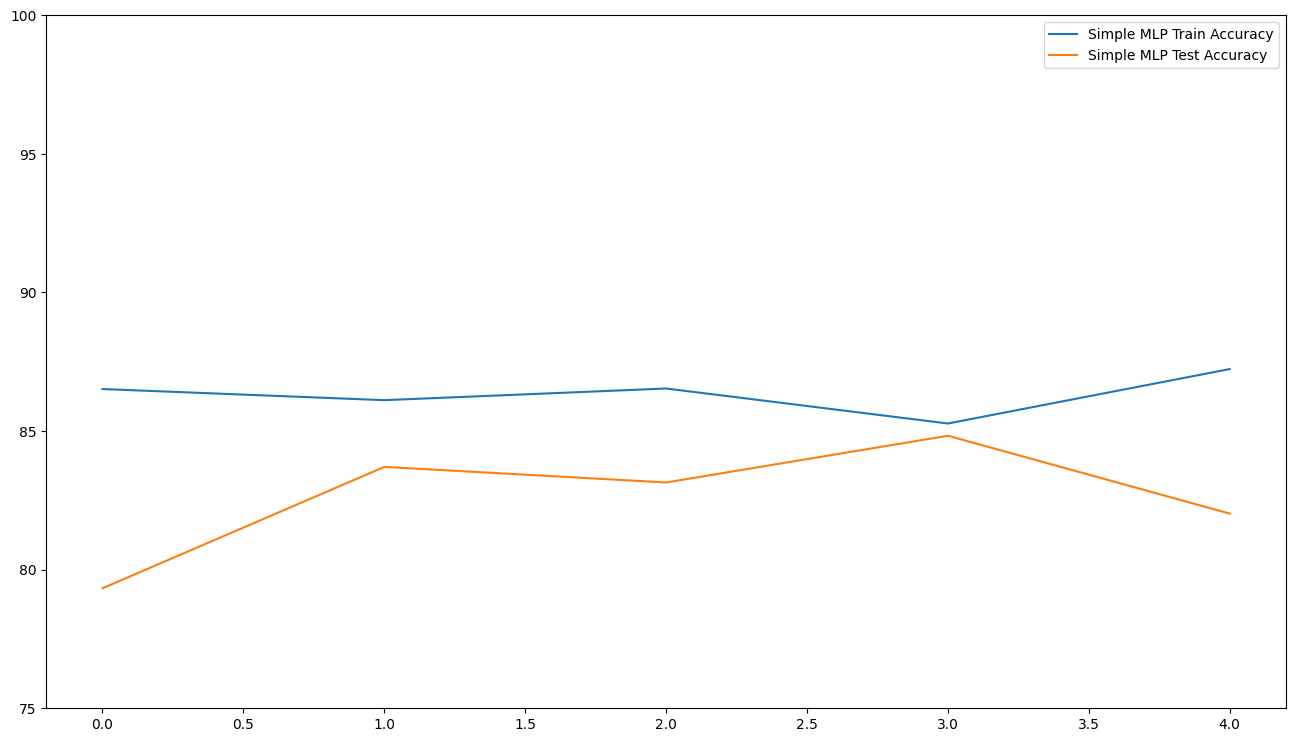

In [590]:
plt.figure(figsize=(16,9))
plt.plot(train_simple, label="Simple MLP Train Accuracy")
plt.plot(test_simple, label="Simple MLP Test Accuracy")
# plt.plot(train_dense, label="Dense MLP Train Accuracy")
# plt.plot(test_dense, label="Dense MLP Test Accuracy")
plt.ylim(75,100)
plt.legend()

In [591]:
model_simple = model_simple.to(device)
X_test = X_test.to(device)

model_simple.eval()
with torch.no_grad():
    y_pred = model_simple(X_test)
    predictions = (y_pred > 0.5).float()


test_ = pd.read_csv('test.csv')
output = test_[['PassengerId']]
output.loc[:, 'Survived'] = predictions.cpu().numpy().astype(int)

output.to_csv('titanic_submission.csv', index=False)
print("Your submission was successfully saved!")

Your submission was successfully saved!


/tmp/ipykernel_57679/158023965.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  output.loc[:, 'Survived'] = predictions.cpu().numpy().astype(int)
